<a href="https://colab.research.google.com/github/umbrasaited/BDA_EXAM/blob/main/BDA_exam_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Big Data Exam: Closest moving vessels in the are

To complete the task of finding two closest moving vessels in a particular sea area and to visualize their trajectory 10 minutes before rendezvous time and 10 minutes after, AIS Dataset was used, as well as Python programming language, Google Collab environment and also Google drive, to store all of the processed files and final results.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Since the task required to find the two closest moving vessels from the time period of December 1, 2021, to December 31, 2021, the 31 .csv files with average size of 1.6 GB were loaded into Google Drive and were all processed separately.
The first step was to remove the noise from the files. Noise removal was performed following this criteria:


1.   Vessels with less than 100 data points;
2.   Removing rows with missing or invalid fields from columns: "MMSI", "Timestamp", "Latitude", "Longitude", "Navigational status", "ROT", "SOG", "COG", "Heading", "Name";
3. Filtering out invalid latitude and longtitude values;
4. Since the result presentation required to print out the name of the vessel, the vessels with no name were filtered out, just to be sure, that they are not included;
5. Filtering out the data within the specified date range. Since the dataset was downloaded only from a specified period in the task, this step could as well be skiped, but was added for a more general approach.
6. Filtering vessels to include only those within a 50 km radius of the specified center coordinates;
7. For each vessel, the code identifies the moment when it is closest to the center and extracts its trajectory within a 20-minute window around this rendezvous moment.

After filtering out the noise, data about two candidate ships is then written to a filtered data .csv file which is the also saved to the Google Drive. Databases (e.g. MongoDB) were not used to complete the task, to not have been dependent on the machine that is used to process the data. No other filtering actions were made and the data noise filtering was performed in the begining, because it yelded better result in the ships having actual trajectory rather than the coordinate data being scattered all over the place and showing other inconsistencies.

Multiprocessing was used to process vessels in parallel. Each file took about 15 minutes to process and write the filtered out data files.

Comments in the code below also provide insight on the steps that were performed, e.g. to set the center coordinates and so on.



In [9]:
from datetime import datetime, timedelta
from geopy.distance import distance
import glob
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
import numpy as np
import pandas as pd

# Load dataset into memory with correct timestamp parsing
df = pd.read_csv('/content/drive/MyDrive/filtered_master_data.csv', parse_dates=['# Timestamp'], dayfirst=True) #requires to change location to where the file is actually stored

# Rename the timestamp column for easier access
df.rename(columns={'# Timestamp': 'Timestamp'}, inplace=True)

# Filter out noise
# Vessels with less than 100 data points
df_clean = df.groupby('MMSI').filter(lambda x: len(x) >= 100)

# Remove rows with missing or invalid fields
valid_columns = ['MMSI', 'Timestamp', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'Name']
df_clean = df_clean.dropna(subset=valid_columns)

# Filter out invalid latitude and longitude values
df_clean = df_clean[(df_clean['Latitude'].between(-90, 90)) & (df_clean['Longitude'].between(-180, 180))]

# Filter out rows where the "Name" column is empty
df_clean = df_clean[df_clean['Name'].notna()]

# Filter data within the specified date range
start_date = datetime(2021, 12, 1)
end_date = datetime(2022, 1, 1)
df_clean = df_clean[(df_clean['Timestamp'] >= start_date) & (df_clean['Timestamp'] <= end_date)]

# Center coordinates
center_coords = (55.225000, 14.245000)
radius_km = 50

The process below shows the whole logic on how the closest vessels were selected.

In [10]:
# Function to check if a point is within the specified radius
def is_within_radius(lat, lon, center_coords, radius_km):
    return distance(center_coords, (lat, lon)).km <= radius_km

# Filter vessels within the 50 km radius
df_clean['WithinRadius'] = df_clean.apply(lambda row: is_within_radius(row['Latitude'], row['Longitude'], center_coords, radius_km), axis=1)
df_radius = df_clean[df_clean['WithinRadius']]

# Find the closest vessels
vessels_in_radius = df_radius['MMSI'].unique()

# Helper function to process each vessel
def process_vessel(mmsi):
    vessel_data = df_radius[df_radius['MMSI'] == mmsi].copy()  # Ensure we are working on a copy

    # Find the rendezvous moment (assuming it's the closest point to the center)
    vessel_data.loc[:, 'DistanceToCenter'] = vessel_data.apply(lambda row: distance(center_coords, (row['Latitude'], row['Longitude'])).km, axis=1)
    rendezvous_index = vessel_data['DistanceToCenter'].idxmin()
    rendezvous_time = vessel_data.loc[rendezvous_index, 'Timestamp']

    # Get 20-minute trajectory around the rendezvous moment
    start_time = rendezvous_time - timedelta(minutes=10)
    end_time = rendezvous_time + timedelta(minutes=10)
    trajectory = vessel_data[(vessel_data['Timestamp'] >= start_time) & (vessel_data['Timestamp'] <= end_time)]

    if len(trajectory) > 0:
        return mmsi, vessel_data.loc[rendezvous_index, 'Name'], trajectory
    else:
        return None

# Use multiprocessing to process vessels in parallel
pool = Pool(cpu_count())
output_data = pool.map(process_vessel, vessels_in_radius)
pool.close()
pool.join()

# Filter out None results
output_data = [data for data in output_data if data is not None]

# Find the two closest vessels
output_data = sorted(output_data, key=lambda x: x[2]['DistanceToCenter'].min())[:2]

# Concatenate the trajectories of the two closest vessels
closest_vessels_data = pd.concat([trajectory for _, _, trajectory in output_data])

After processing and filtering out the noise form all of the 31 files, the results were combined to a one "filtered_ais_data.csv", from which the final selection of the two closest moving vessels, in the period December 1, 2021, to December 31, 2021, was made.
The trajectories of the two vessels are the visualized having also printed out their MMSI and Name. Latitude and Longtitude are presented in the diagrams, to show how close they were to the selected center coordinates.

The identified closest vessels where:


1.   Vessel MMSI: 219021321, Name: SILVER KENNA from 2021-12-22 (time period: 16:26:30 - 16:46:04)
2.   Vessel MMSI: 230948000, Name: CONTAINERSHIPS VII from 2021-12-25 (time period: 02:52:55 - 03:12:55)



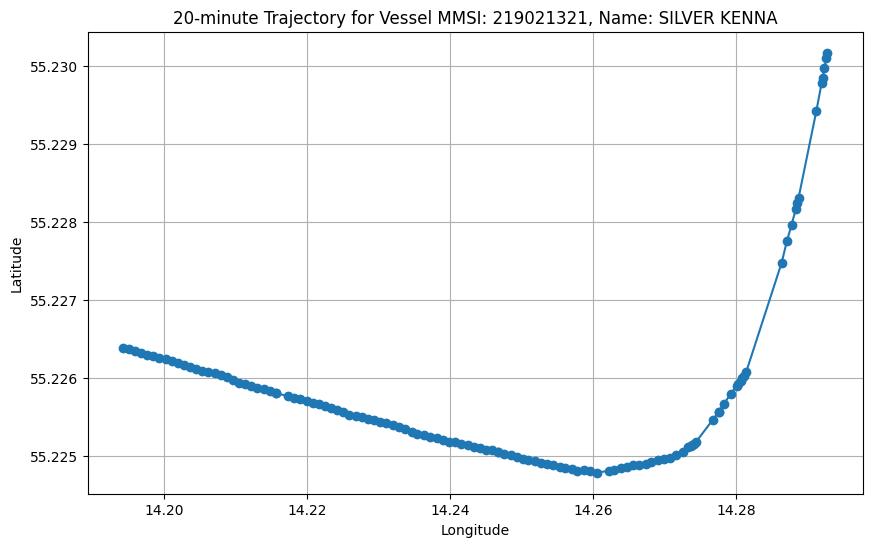

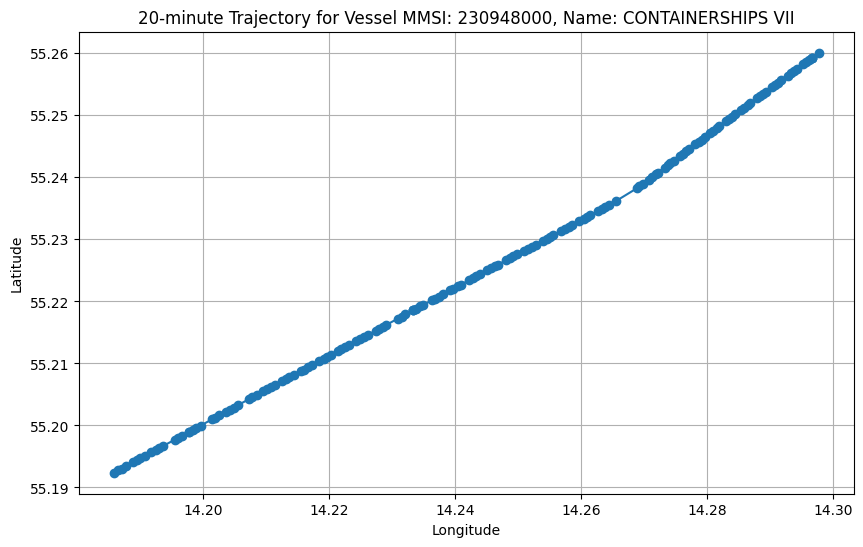

Vessel MMSI: 219021321, Name: SILVER KENNA
Vessel MMSI: 230948000, Name: CONTAINERSHIPS VII


In [11]:
# Write the data points of the two closest vessels to a new CSV file
closest_vessels_data.to_csv('/content/drive/MyDrive/filtered_ais_data.csv', index=False) #requires to change the location of where we want to store the file

# Visualize the trajectories of the two closest vessels
for mmsi, name, trajectory in output_data:
    plt.figure(figsize=(10, 6))
    plt.plot(trajectory['Longitude'], trajectory['Latitude'], marker='o')
    plt.title(f'20-minute Trajectory for Vessel MMSI: {mmsi}, Name: {name}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()

# Output the MMSI and names of the vessels
for mmsi, name, trajectory in output_data:
    print(f'Vessel MMSI: {mmsi}, Name: {name}')

In this version below the code functionalities of data filtering are the same except the two closest moving ships are identified for one specific day and their moving trajectories are visualized in one diagram.
The day that was selected is 2021-12-22 with the ships:


*   Vessel MMSI: 219021321, Name: SILVER KENNA (time period: 16:26:30 - 16:46:04)
*   Vessel MMSI: 255805993, Name: RIX ELEONORA (time period: 16:35:34 - 16:55:03)

Making their meeting time at around 16:35.



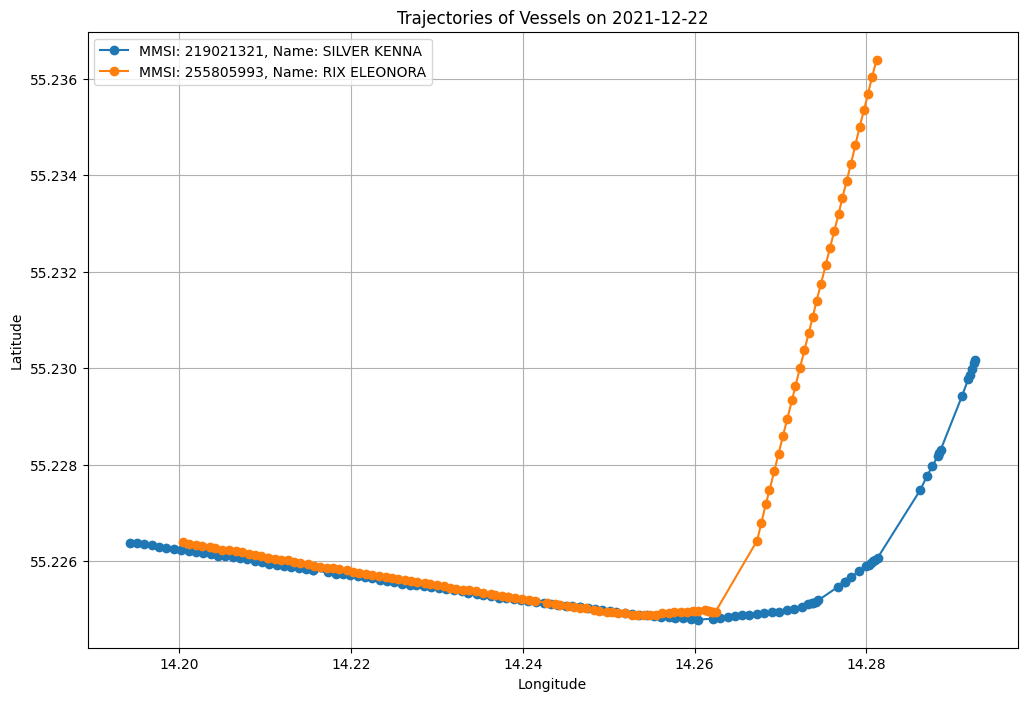

Date: 2021-12-22
  Vessel MMSI: 219021321, Name: SILVER KENNA
  Vessel MMSI: 255805993, Name: RIX ELEONORA


In [14]:
# Load dataset into memory with correct timestamp parsing
df = pd.read_csv('/content/drive/MyDrive/filtered_master_data.csv', parse_dates=['# Timestamp'], dayfirst=True)  # Change to the actual file location

# Rename the timestamp column for easier access
df.rename(columns={'# Timestamp': 'Timestamp'}, inplace=True)

# Filter out noise
# Vessels with less than 100 data points
df_clean = df.groupby('MMSI').filter(lambda x: len(x) >= 100)

# Remove rows with missing or invalid fields
valid_columns = ['MMSI', 'Timestamp', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'Name']
df_clean = df_clean.dropna(subset=valid_columns)

# Filter out invalid latitude and longitude values
df_clean = df_clean[(df_clean['Latitude'].between(-90, 90)) & (df_clean['Longitude'].between(-180, 180))]

# Filter out rows where the "Name" column is empty
df_clean = df_clean[df_clean['Name'].notna()]

# Filter data within the specified date range
start_date = datetime(2021, 12, 1)
end_date = datetime(2022, 1, 1)
df_clean = df_clean[(df_clean['Timestamp'] >= start_date) & (df_clean['Timestamp'] <= end_date)]

# Center coordinates
center_coords = (55.225000, 14.245000)
radius_km = 50
# Function to check if a point is within the specified radius
def is_within_radius(lat, lon, center_coords, radius_km):
    return distance(center_coords, (lat, lon)).km <= radius_km

# Filter vessels within the 50 km radius
df_clean['WithinRadius'] = df_clean.apply(lambda row: is_within_radius(row['Latitude'], row['Longitude'], center_coords, radius_km), axis=1)
df_radius = df_clean[df_clean['WithinRadius']]

# Find the closest vessels
vessels_in_radius = df_radius['MMSI'].unique()

# Helper function to process each vessel
def process_vessel(mmsi):
    vessel_data = df_radius[df_radius['MMSI'] == mmsi].copy()  # Ensure we are working on a copy

    # Find the rendezvous moment (assuming it's the closest point to the center)
    vessel_data['DistanceToCenter'] = vessel_data.apply(lambda row: distance(center_coords, (row['Latitude'], row['Longitude'])).km, axis=1)
    rendezvous_index = vessel_data['DistanceToCenter'].idxmin()
    rendezvous_time = vessel_data.loc[rendezvous_index, 'Timestamp']

    # Get 20-minute trajectory around the rendezvous moment
    start_time = rendezvous_time - timedelta(minutes=10)
    end_time = rendezvous_time + timedelta(minutes=10)
    trajectory = vessel_data[(vessel_data['Timestamp'] >= start_time) & (vessel_data['Timestamp'] <= end_time)]

    if len(trajectory) > 0:
        return mmsi, vessel_data.loc[rendezvous_index, 'Name'], trajectory
    else:
        return None

# Use multiprocessing to process vessels in parallel
pool = Pool(cpu_count())
output_data = pool.map(process_vessel, vessels_in_radius)
pool.close()
pool.join()

# Filter out None results
output_data = [data for data in output_data if data is not None]


# Organize the data by date
daily_trajectories = {}
for data in output_data:
    mmsi, name, trajectory = data
    for date in trajectory['Timestamp'].dt.date.unique():
        day_trajectory = trajectory[trajectory['Timestamp'].dt.date == date]
        if date not in daily_trajectories:
            daily_trajectories[date] = []
        daily_trajectories[date].append((mmsi, name, day_trajectory))

# Find the day with the closest vessels to the center coordinates
min_distance = float('inf')
closest_day = None
for date, vessels in daily_trajectories.items():
    day_min_distance = min([trajectory['DistanceToCenter'].min() for _, _, trajectory in vessels])
    if day_min_distance < min_distance:
        min_distance = day_min_distance
        closest_day = date

# Visualize the trajectories of the vessels on the closest day
if closest_day:
    plt.figure(figsize=(12, 8))
    for mmsi, name, trajectory in daily_trajectories[closest_day]:
        plt.plot(trajectory['Longitude'], trajectory['Latitude'], marker='o', label=f'MMSI: {mmsi}, Name: {name}')
    plt.title(f'Trajectories of Vessels on {closest_day}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Output the MMSI and names of the vessels for the closest day
    print(f'Date: {closest_day}')
    for mmsi, name, trajectory in daily_trajectories[closest_day]:
        print(f'  Vessel MMSI: {mmsi}, Name: {name}')
else:
    print("No vessels found within the specified radius.")



**Combining .csv files**
Helper function to combine all of the filtered files from 2021-12-01 to 2021-12-31.

In [ ]:
def combine_csv_files(input_folder, output_file):
    # Use glob to get all CSV files in the input folder
    all_files = glob.glob(f"{input_folder}/*.csv")

    # List to store DataFrames
    df_list = []

    # Loop through the files and read each one into a DataFrame
    for file in all_files:
        df = pd.read_csv(file)
        df_list.append(df)

    # Concatenate all DataFrames
    combined_df = pd.concat(df_list, ignore_index=True)

    # Write the combined DataFrame to a master CSV file
    combined_df.to_csv(output_file, index=False)

# Example usage since it's required to change the folder location of where the files are actually stored
input_folder = '/content/drive/MyDrive/Filtered_data'
output_file = '/content/drive/MyDrive/filtered_master_data.csv'
combine_csv_files(input_folder, output_file)
